# Selecting and tracking particles

This notebook explains how to select and track particles, with openPMD-viewer.

In this notebook:
- **selecting** means extracting the particles that satisfy a given set of criteria (e.g. in terms of energy or position) at a given iteration.
- **tracking** means selecting particles at one iteration, and then retrieving the same particles at another iterations.

**Note:** Tracking particles requires the particle ID to be stored in the openPMD files.

## (optional) Preparing this notebook to run it locally

If you choose to run this notebook on your local machine, you will need to download the openPMD data files which will then be visualized. To do so, and execute the following cell.

## Dataset Description
Generated by Warpx, on single node, by 32 processes
Size: ~ 66 GB
Command: mpirun -np 32 ./warpx inputs_3d_512
Time: ~ 3 hrs

Node information:
CPU: Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz
Drive: Kioxia KRM6VRUG3T84 SED 3.84TB

**inputs_3d_512** core parameters:
amr.n_cell = 512 512 512
electrons.density = 2.e24  # number of electrons per m^3



R-tree node structure

syntax = "proto3";

message TreeNode {
  int32 level = 1;
  int32 childSize = 2;
  double minx = 3;
  double maxx = 4;
  double miny = 5;
  double maxy = 6;
  double minz = 7;
  double maxz = 8;
  int32 start = 9;
  int32 end = 10;
  bytes bloom_filter = 11;
}

## build Geos_index
asynchronous building geos index after data generation.

single thread, can be optimized by multi-threads in the future

Time: ~ 0.5 hr
Index db size: 4.7 GB (Without any compression, per_key_hash_time=10, bloom filter in each tree node = 10000 bits)

Time: ~ 0.5 hr
Index db size: 0.47 GB (Without any compression, per_key_hash_time=5, bloom filter in each tree node = 400 bits)

In [ ]:
# %%time
import geosindex
# built_object = geosindex.BuildGEOSIndex(
#     "/data/gc/rocksdb-index/WarpX/build/bin/diags/diag2/openpmd.bp",
#     ["position", "momentum"],
#     "",  # rocksdb save path, by defaults is {bpFilePath}/rocksdb. In this case, e.g. "/data/gc/rocksdb-index/WarpX/build/bin/diags/diag2/rocksdb"
#     "electrons",
#     10,
#     10,
#     10000
# )
# built_object.buildFirstSTRtree3d()

## Preparing the API

First, we import matplotlib and numpy, and we impose that the plots are incorporated inside the notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openpmd_viewer import OpenPMDTimeSeries

As usual, in order to use openPMD-viewer, we:
- load the class `OpenPMDTimeSeries` from the module `openpmd_viewer`
- create a time series object by pointing to the folder which contains the corresponding openPMD data

In [2]:
%%time
ts = OpenPMDTimeSeries("/data/gc/rocksdb-index/WarpX/build/bin/diags/diag2/")

CPU times: user 77.8 ms, sys: 32.6 ms, total: 110 ms
Wall time: 110 ms


In [3]:
%%time
geos_ts = OpenPMDTimeSeries("/data/gc/rocksdb-index/WarpX/build/bin/diags/diag2/", backend='openpmd-api', geos_index=True,
                       rocksdb_path="/data/gc/rocksdb-index/WarpX/build/bin/diags/diag2/rocksdb")

Open RocksDB successfully! DB path: /data/gc/rocksdb-index/WarpX/build/bin/diags/diag2/rocksdb
CPU times: user 126 ms, sys: 37.6 ms, total: 164 ms
Wall time: 159 ms


## Data Overview (z, uz at iteration 300)

read data from disk: z
read data from disk: uz

read data from disk: w


/data/gc/rocksdb-index/openPMD-viewer/openpmd_viewer/openpmd_timeseries/plotter.py:406: UserWarning: 
CIC particle histogramming is unavailable because 
Numba is not installed. NGP histogramming is used instead.
Please considering installing numba (e.g. `pip install numba`)
  warnings.warn(


the number of particles is: 29007072
CPU times: user 38.2 s, sys: 896 ms, total: 39.1 s
Wall time: 39 s


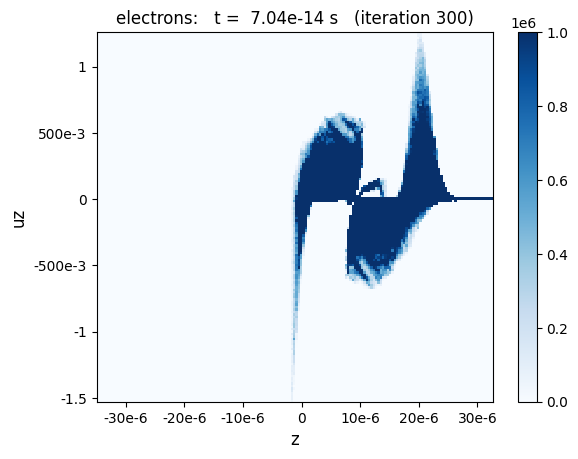

In [4]:
%%time
z_all, uz_all = ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True, vmax=1e6 )
print(f"the number of particles is: {len(z_all)}")

## One dimension select criteria, e.g. select={'z': xx to xx } in this case

## roughly 3% of the whole dataset

In [21]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[2.05e-6, 2.10e-6]})

read data from disk: z
read data from disk: uz
read data from disk: z

the number of particles is: 23246
CPU times: user 36.9 s, sys: 648 ms, total: 37.6 s
Wall time: 37.5 s


In [ ]:
plt.plot(z_selected, uz_selected, 'g.')

In [4]:
%%time
z_geos_selected, uz_geos_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[2.05e-6, 2.10e-6]})

first level match num: 264
read data from disk: z
second level match num: 1636
read data from disk: uz


CPU times: user 5.01 s, sys: 58.6 ms, total: 5.07 s
Wall time: 5.06 s


In [5]:
%%time
z_geos_selected, uz_geos_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[2.05e-6, 2.10e-6]}, direct_block_read=True)

first level match num: 264
read data from disk: z
read data from disk: uz


CPU times: user 1.14 s, sys: 53.8 ms, total: 1.2 s
Wall time: 1.2 s


In [ ]:
plt.plot(z_geos_selected, uz_geos_selected, 'g.')

In [ ]:
print(f"the number of ts selected particles is: {len(z_selected)}")
print(f"the number of geos_ts selected particles is: {len(z_geos_selected)}")
print(f"the proportion is: {len(z_selected) / len(z_all)}")

## roughly 0.08% of the whole dataset

In [ ]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[2.05e-6, 2.10e-6]})
print(f"the number of particles is: {len(z_selected)}")

if select is not set, geos_index would use openPMD-viewer default reader

For the warning, numba is not installed. I have tried to install numba, but the figure didn't show up for 10 minutes...

In [12]:
%%time
# without select
z_all, uz_all = ts.get_particle( ['z', 'uz'], species='electrons', iteration=300)

read data from disk: z
read data from disk: uz

CPU times: user 1min 1s, sys: 592 ms, total: 1min 2s
Wall time: 1min 2s


In [5]:
%%time
# select 75% data by set criteria on z
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[0, 25e-6]})
print(f"the number of particles is: {len(z_selected)}")

read data from disk: z
read data from disk: uz
read data from disk: z

the number of particles is: 21916318
CPU times: user 37.2 s, sys: 761 ms, total: 38 s
Wall time: 37.9 s


Default openPMD-viewer reads variables for 3 times. ['z', 'uz'] and z in select. (29007072 * 3)

Then apply selection on z, which costs 2 x 29007072 comparison.

Check lower bound
if select[quantity][0] is not None:
    select_array = np.logical_and(
        select_array,
        data_map[quantity] > select[quantity][0])
Check upper bound
if select[quantity][1] is not None:
    select_array = np.logical_and(
        select_array,
        data_map[quantity] < select[quantity][1])

In [7]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[0, 25e-6]})
print(f"the number of particles is: {len(z_selected)}")

first level match num: 6404
second level match num: 223600
read data from disk: z
read data from disk: uz


the number of particles is: 21916318
CPU times: user 11min 5s, sys: 1.47 s, total: 11min 7s
Wall time: 11min 7s


For 75% proportion, geos_index performs really **bad** since second level = 223600 and each slice has 100 particles.
Overhead:
1. For now, it needs reading block for 223600 x 2 times, because we use openPMD-api here to read each slice, which means this equal to 223600 x 2 times of ADIOS block read
2. The geos index totally persists on the disk, there is 6404 + 1 times reading z from Rocksdb

Future possible optimization:
1. Organize the slices in the same block before ADIOS block IO. In this way, we can reduce ADIOS block IO to 6404, and organize target slice in memory.
2. Apply multiple threads to read ADIOS block
3. Depends on index size, we can choose to cache all the index in memory when initializing.

In [7]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[0, 25e-6]}, direct_block_read=True)
print(f"the number of particles is: {len(z_selected)}")

first level match num: 6404
read data from disk: z
read data from disk: uz


the number of particles is: 21916318
CPU times: user 26.3 s, sys: 822 ms, total: 27.1 s
Wall time: 27.1 s


In [6]:
print(f"the proportion is: {len(z_selected) / len(z_all)}")

the proportion is: 0.7555508532539926


In [12]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[10e-6, 25e-6]})
print(f"the number of particles is: {len(z_selected)}")

read data from disk: z
read data from disk: uz
read data from disk: z

the number of particles is: 13172352
CPU times: user 37.2 s, sys: 716 ms, total: 37.9 s
Wall time: 37.8 s


In [8]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[10e-6, 25e-6]})
print(f"the number of particles is: {len(z_selected)}")

first level match num: 3960
second level match num: 136528
read data from disk: z
read data from disk: uz


the number of particles is: 13172352
CPU times: user 6min 47s, sys: 927 ms, total: 6min 48s
Wall time: 6min 48s


In [6]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[10e-6, 25e-6]}, direct_block_read=True)
print(f"the number of particles is: {len(z_selected)}")

first level match num: 3960
read data from disk: z
read data from disk: uz


the number of particles is: 13172352
CPU times: user 14.9 s, sys: 531 ms, total: 15.4 s
Wall time: 15.4 s


In [11]:
print(f"the proportion is: {len(z_selected) / len(z_all)}")

the proportion is: 0.45410829469448


In [13]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[20e-6, 25e-6]})
print(f"the number of particles is: {len(z_selected)}")

read data from disk: z
read data from disk: uz
read data from disk: z

the number of particles is: 4496414
CPU times: user 37.1 s, sys: 704 ms, total: 37.8 s
Wall time: 37.7 s


In [9]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[20e-6, 25e-6]})
print(f"the number of particles is: {len(z_selected)}")

first level match num: 1584
second level match num: 49693
read data from disk: z
read data from disk: uz


the number of particles is: 4496414
CPU times: user 2min 28s, sys: 396 ms, total: 2min 29s
Wall time: 2min 29s


In [8]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[20e-6, 25e-6]}, direct_block_read=True)
print(f"the number of particles is: {len(z_selected)}")

read data from disk: zfirst level match num: 1584

read data from disk: uz


the number of particles is: 4496414
CPU times: user 10 s, sys: 166 ms, total: 10.2 s
Wall time: 10.2 s


In [14]:
print(f"the proportion is: {len(z_selected) / len(z_all)}")

the proportion is: 0.15501095732792333


In [15]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[20e-6, 21e-6]})
print(f"the number of particles is: {len(z_selected)}")

read data from disk: z
read data from disk: uz
read data from disk: z

the number of particles is: 945518
CPU times: user 36.9 s, sys: 680 ms, total: 37.6 s
Wall time: 37.5 s


In [17]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[20e-6, 21e-6]})
print(f"the number of particles is: {len(z_selected)}")

first level match num: 528
second level match num: 12894
read data from disk: z
read data from disk: uz


the number of particles is: 945518
CPU times: user 38.2 s, sys: 128 ms, total: 38.3 s
Wall time: 38.3 s


In [8]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[20e-6, 21e-6]}, direct_block_read=True)
print(f"the number of particles is: {len(z_selected)}")

first level match num: 528
read data from disk: uz
read data from disk: z


the number of particles is: 945518
CPU times: user 3.02 s, sys: 33.8 ms, total: 3.05 s
Wall time: 3.05 s


In [16]:
print(f"the proportion is: {len(z_selected) / len(z_all)}")

the proportion is: 0.03259612000825178


In [10]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[2.05e-6, 2.10e-6]})
print(f"the number of particles is: {len(z_selected)}")

read data from disk: zfirst level match num: 264

second level match num: 1636
read data from disk: uz


the number of particles is: 23246
CPU times: user 5.32 s, sys: 12 ms, total: 5.33 s
Wall time: 5.33 s


In [13]:
print(f"the proportion is: {len(z_selected) / len(z_all)}")

the proportion is: 0.0008013907780833584


In [38]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[2.10e-6, 2.10e-6]})
print(f"the number of particles is: {len(z_selected)}")

read data from disk: z
read data from disk: uz
read data from disk: z

the number of particles is: 0
CPU times: user 37.4 s, sys: 700 ms, total: 38.1 s
Wall time: 38 s


In [14]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[2.10e-6, 2.10e-6]})
print(f"the number of particles is: {len(z_selected)}")

read data from disk: z
first level match num: 258
second level match num: 1316
read data from disk: uz


the number of particles is: 0
CPU times: user 4.1 s, sys: 20 ms, total: 4.12 s
Wall time: 4.11 s


In [15]:
print(f"the proportion is: {len(z_selected) / len(z_all)}")

the proportion is: 0.0


## multi dimension select criteria in position, e.g. select={'z': xx to xx, 'x': and 'y': } in this case

In [6]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[37e-6, 40e-6], 'uz':[0.7, 1.0]})
print(len(z_selected))

read data from disk: z
read data from disk: uz
read data from disk: z
read data from disk: uz

0
CPU times: user 50.1 s, sys: 959 ms, total: 51.1 s
Wall time: 50.9 s


In [4]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[37e-6, 40e-6], 'x':[5e-3, 10e-3]})
print(len(z_selected))

read data from disk: z
read data from disk: uz
read data from disk: z
read data from disk: x

0
CPU times: user 50.2 s, sys: 779 ms, total: 51 s
Wall time: 50.8 s


In [5]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[37e-6, 40e-6], 'x':[5e-3, 10e-3], 'y':[5e-3, 10e-3]})
print(len(z_selected))

read data from disk: z
read data from disk: uz
read data from disk: z
read data from disk: x
read data from disk: y

0
CPU times: user 1min 2s, sys: 931 ms, total: 1min 3s
Wall time: 1min 3s


read data from disk: zfirst level match num: 264

second level match num: 2460
read data from disk: uz


the number of particles is: 166
CPU times: user 7.42 s, sys: 48 ms, total: 7.47 s
Wall time: 7.47 s


In [34]:
print(f"the proportion is: {len(z_selected) / len(z_all)}")

the proportion is: 0.004791383287496236


In [ ]:
ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True, vmax=1e6 )
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[37e-6, 40e-6], 'uz':[5e-3, 10e-3]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

first level match num: 120
read data from disk: y
second level match num: 4904
read data from disk: x
read data from disk: z
read data from disk: uz


138984
CPU times: user 29 s, sys: 81 ms, total: 29.1 s
Wall time: 29.1 s


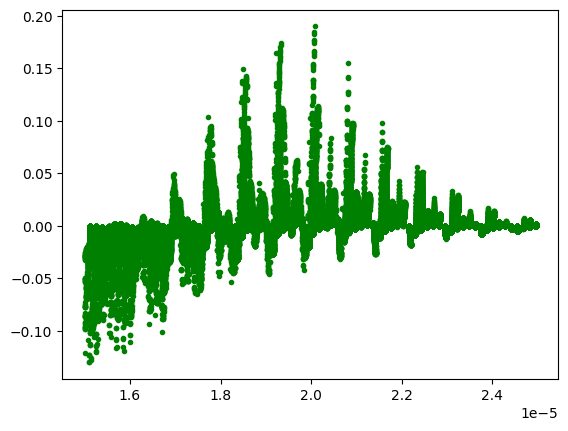

In [33]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'x':[5e-6, 10e-6], 'y':[-10e-6, -5e-6], 'z':[15e-6, 25e-6]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

## Selecting particles that satisfy a set of conditions

In order to select particles according to a set of criteria, one needs to pass these criteria to the method `get_particle` as a dictionary, using the keyword argument `select`, as in the example below:

using openpmd-api backend to read data
using openpmd-api backend to read data

using openpmd-api backend to read data
using openpmd-api backend to read data

12158
CPU times: user 1min 28s, sys: 1.82 s, total: 1min 30s
Wall time: 1min 30s


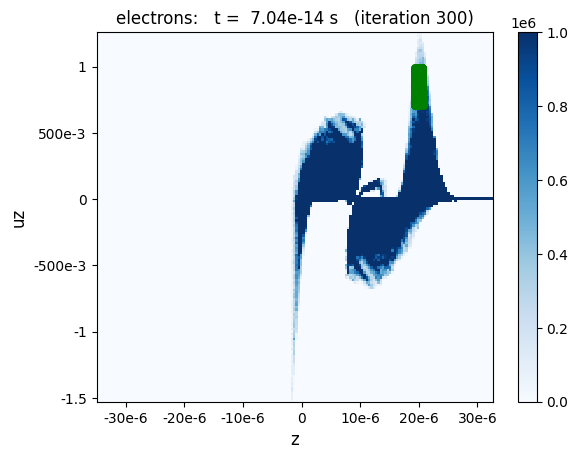

In [6]:
%%time
from openpmd_viewer import OpenPMDTimeSeries
ts = OpenPMDTimeSeries("/data/gc/rocksdb-index/WarpX/build/bin/diags/diag2/")
ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True, vmax=1e6 )
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[19e-6, 21e-6], 'uz':[0.7, 1.0]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

using openpmd-api backend to read data
using openpmd-api backend to read data

CPU times: user 39 s, sys: 767 ms, total: 39.8 s
Wall time: 39.7 s


[array([-1.14138486e-06, -1.13514335e-06, -1.13950245e-06, ...,
         3.22539063e-05,  3.22539063e-05,  3.22539063e-05]),
 array([-6.34365163e-01, -5.90070040e-01, -6.21004136e-01, ...,
         2.82545956e-15,  2.32997985e-15,  1.74478188e-15])]

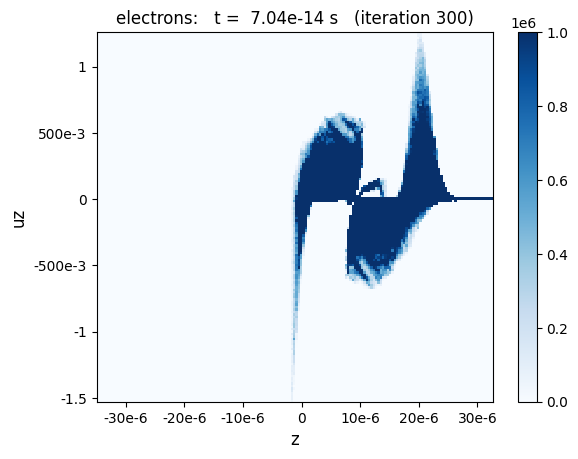

In [10]:
%%time
ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True, vmax=1e6 )

using openpmd-api backend to read data
using openpmd-api backend to read data

12158
CPU times: user 49.9 s, sys: 1 s, total: 50.9 s
Wall time: 50.8 s


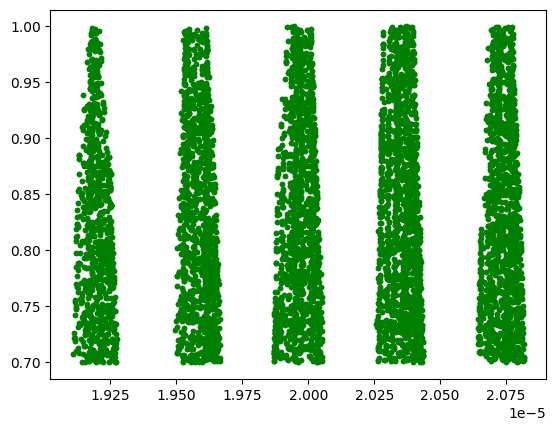

In [9]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[19e-6, 21e-6], 'uz':[0.7, 1.0]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

first level match num: 792
second level match num: 20866
first level match num: 78
second level match num: 2327
read data from disk: uz
read data from disk: z


12158
CPU times: user 6.29 s, sys: 59.3 ms, total: 6.35 s
Wall time: 6.35 s


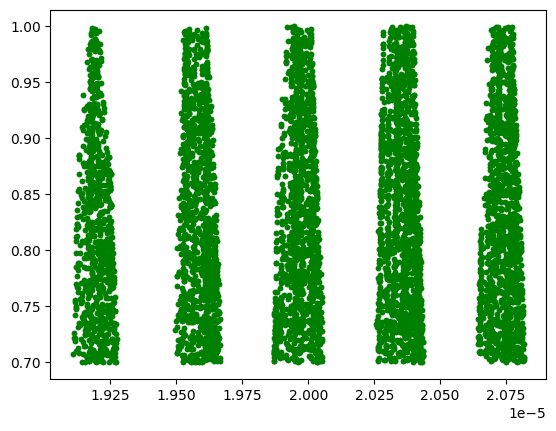

In [5]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[19e-6, 21e-6], 'uz':[0.7, 1.0]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

first level match num: 792
first level match num: 78
read data from disk: z
read data from disk: uz


12158
CPU times: user 594 ms, sys: 65 ms, total: 659 ms
Wall time: 656 ms


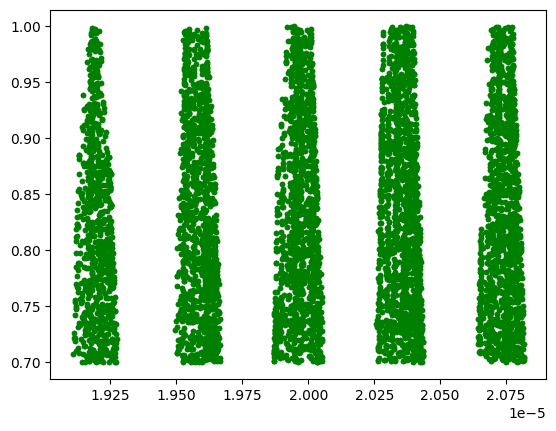

In [4]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[19e-6, 21e-6], 'uz':[0.7, 1.0]}, direct_block_read=True )
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

using openpmd-api backend to read data
using openpmd-api backend to read data



/data/gc/rocksdb-index/openPMD-viewer/openpmd_viewer/openpmd_timeseries/plotter.py:406: UserWarning: 
CIC particle histogramming is unavailable because 
Numba is not installed. NGP histogramming is used instead.
Please considering installing numba (e.g. `pip install numba`)
  warnings.warn(


CPU times: user 38.9 s, sys: 871 ms, total: 39.8 s
Wall time: 39.7 s


[array([-7.05166564e-08, -3.52456316e-07, -2.11523464e-07, ...,
         1.52929688e-05,  1.51757813e-05,  1.50585938e-05]),
 array([-5.05243650e-06, -5.05397207e-06, -5.05286503e-06, ...,
         1.97460937e-05,  1.97460937e-05,  1.97460937e-05])]

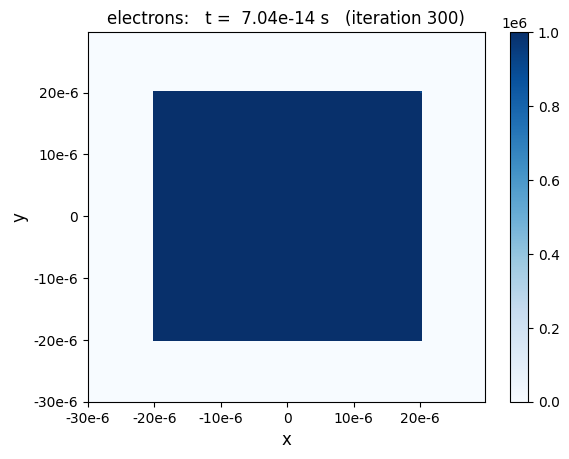

In [13]:
%%time
ts.get_particle( ['x', 'y'], species='electrons', iteration=300, plot=True, vmax=1e6 )

using openpmd-api backend to read data
using openpmd-api backend to read data



/data/gc/rocksdb-index/openPMD-viewer/openpmd_viewer/openpmd_timeseries/plotter.py:406: UserWarning: 
CIC particle histogramming is unavailable because 
Numba is not installed. NGP histogramming is used instead.
Please considering installing numba (e.g. `pip install numba`)
  warnings.warn(


CPU times: user 39.5 s, sys: 1 s, total: 40.5 s
Wall time: 40.4 s


[array([-5.37921956e-03, -2.68983925e-02, -1.61369304e-02, ...,
        -3.79800231e-16, -4.56113903e-16, -5.38319818e-16]),
 array([-1.12715835e+00, -1.09288325e+00, -1.11683918e+00, ...,
        -9.01456861e-14, -9.25255166e-14, -9.44130866e-14])]

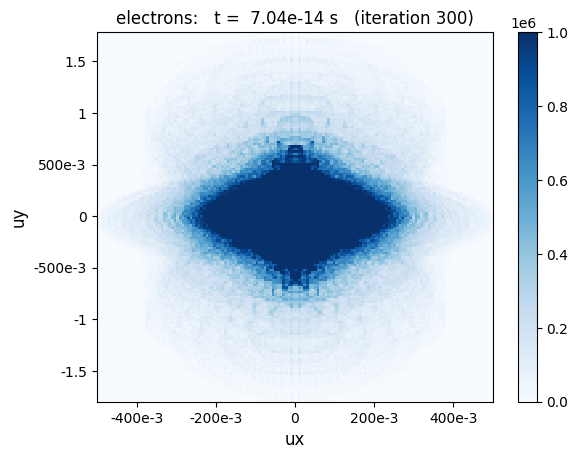

In [24]:
%%time
ts.get_particle( ['ux', 'uy'], species='electrons', iteration=300, plot=True, vmax=1e6 )

using openpmd-api backend to read data
using openpmd-api backend to read data

960
CPU times: user 1min 2s, sys: 1.03 s, total: 1min 3s
Wall time: 1min 3s


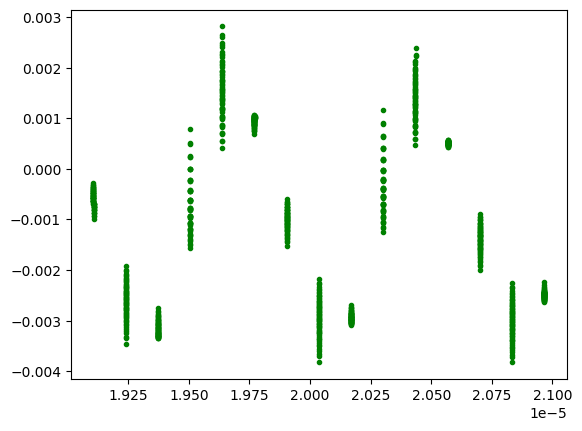

using openpmd-api backend to read data
using openpmd-api backend to read data

6
CPU times: user 8min 42s, sys: 3.4 s, total: 8min 45s
Wall time: 8min 45s


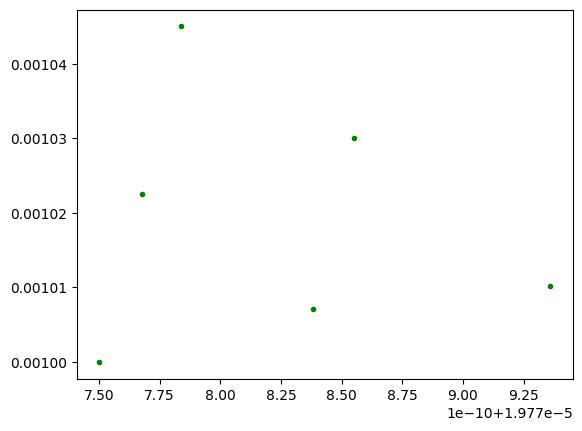

In [33]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'x':[9e-6, 10e-6], 'y':[-10e-6, -9e-6], 'z':[19e-6, 20e-6], 'ux':[0, 0.1], 'uy':[0, 0.1], 'uz':[0, 0.1]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

Open RocksDB successfully! DB path: /data/gc/rocksdb-index/WarpX/build/bin/diags/diag2/rocksdb
using openpmd-api backend to read data
using openpmd-api backend to read data



/data/gc/rocksdb-index/openPMD-viewer/openpmd_viewer/openpmd_timeseries/plotter.py:406: UserWarning: 
CIC particle histogramming is unavailable because 
Numba is not installed. NGP histogramming is used instead.
Please considering installing numba (e.g. `pip install numba`)
  warnings.warn(


first level match num: 792
second level match num: 20866
first level match num: 78
second level match num: 2327


12158
CPU times: user 47.5 s, sys: 2.71 s, total: 50.2 s
Wall time: 50.9 s


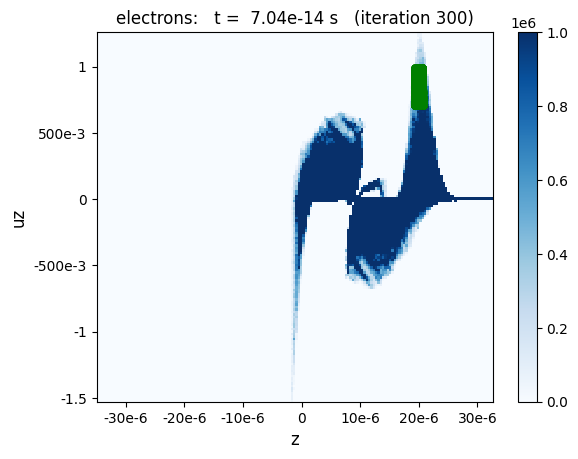

In [7]:
%%time
from openpmd_viewer import OpenPMDTimeSeries
geos_ts = OpenPMDTimeSeries("/data/gc/rocksdb-index/WarpX/build/bin/diags/diag2/", backend='openpmd-api', geos_index=True,
                       rocksdb_path="/data/gc/rocksdb-index/WarpX/build/bin/diags/diag2/rocksdb")
geos_ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True, vmax=1e6 )
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[19e-6, 21e-6], 'uz':[0.7, 1.0]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

first level match num: 792
second level match num: 20866
first level match num: 78
second level match num: 2327


12158
CPU times: user 6.37 s, sys: 79.9 ms, total: 6.45 s
Wall time: 6.45 s


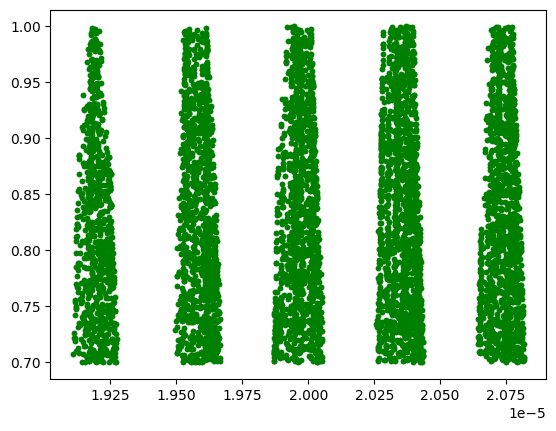

In [12]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[19e-6, 21e-6], 'uz':[0.7, 1.0]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

In [ ]:
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[19e-6, 21e-6], 'uz':[0.7, 1.0]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

first level match num: 1
second level match num: 13


8
CPU times: user 115 ms, sys: 7.92 ms, total: 123 ms
Wall time: 122 ms


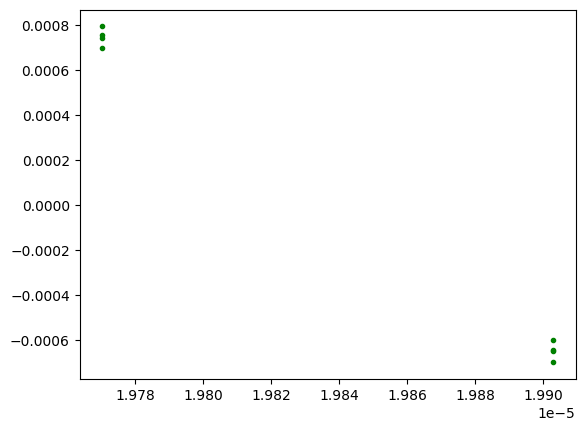

In [23]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'x':[97e-7, 10e-6], 'y':[-10e-6, -97e-7], 'z':[197e-7, 20e-6]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

first level match num: 4
second level match num: 59
first level match num: 4360
second level match num: 110400


6
CPU times: user 1.17 s, sys: 136 ms, total: 1.31 s
Wall time: 1.3 s


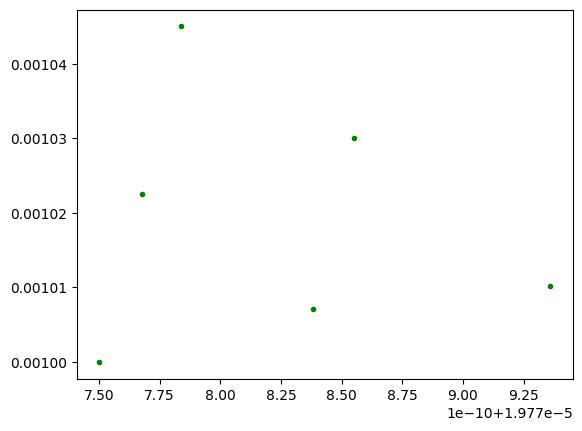

In [32]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'x':[9e-6, 10e-6], 'y':[-10e-6, -9e-6], 'z':[19e-6, 20e-6], 'ux':[0, 0.1], 'uy':[0, 0.1], 'uz':[0, 0.1]})
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

As can be seen from the example above, the format of the `select` dictionary is as follow:
- the key is a string which indicates a particle quantity
- the value is a list of two elements, which represent the bounds between which this quantity should be, for the particles to be retained.

Several criteria can be combined, by entering several key-value pairs in the `select` dictionary, as shown below:

using openpmd-api backend to read data
using openpmd-api backend to read data

2
CPU times: user 47 ms, sys: 6.46 ms, total: 53.4 ms
Wall time: 51.2 ms


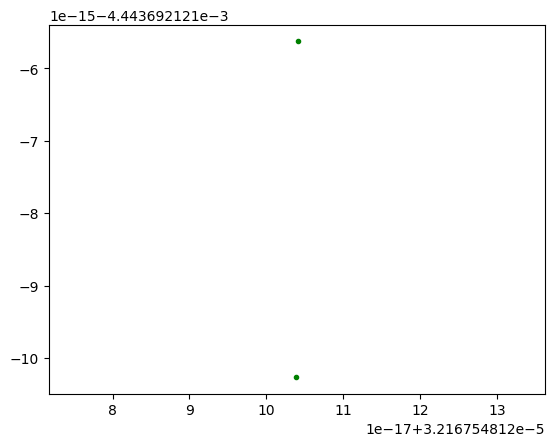

In [7]:
%%time
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'x':[-6.996e-7, 6.996e-7], 'y':[-0.06996e-7, 0.06996e-7], 'z':[22e-6,40e-6]} )
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

using openpmd-api backend to read data
using openpmd-api backend to read data

using openpmd-api backend to read data
using openpmd-api backend to read data

CPU times: user 144 ms, sys: 60.7 ms, total: 205 ms
Wall time: 156 ms


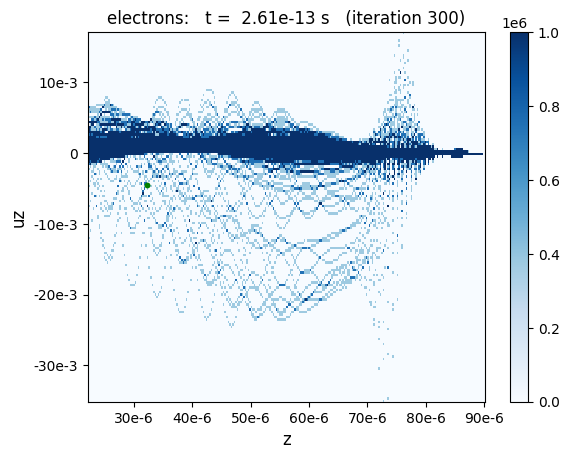

In [8]:
%%time

# Plot the blue phase space with all the electrons
ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True,vmax=1e6 );

# Select only particles that have uz between 0.05 and 0.2 AND z between 22 and 26
# and plot them as green dots, on top of the phase space
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons', 
                            iteration=300, select={'x':[-6.996e-7, 6.996e-7], 'y':[-0.06996e-7, 0.06996e-7], 'z':[22e-6,40e-6]} )
plt.plot(z_selected, uz_selected, 'g.')

In [9]:
%%time
from openpmd_viewer import OpenPMDTimeSeries
geos_ts = OpenPMDTimeSeries("/data/gc/rocksdb-index/WarpX/build/bin/diags/diag1/", backend='openpmd-api', geos_index=True,
                       rocksdb_path="/data/gc/rocksdb-index/WarpX/build/bin/diags/diag1/rocksdb")

Open RocksDB successfully! DB path: /data/gc/rocksdb-index/WarpX/build/bin/diags/diag1/rocksdb
CPU times: user 33.6 ms, sys: 0 ns, total: 33.6 ms
Wall time: 57.9 ms


using openpmd-api backend to read data
using openpmd-api backend to read data

CPU times: user 61.6 ms, sys: 0 ns, total: 61.6 ms
Wall time: 60.1 ms


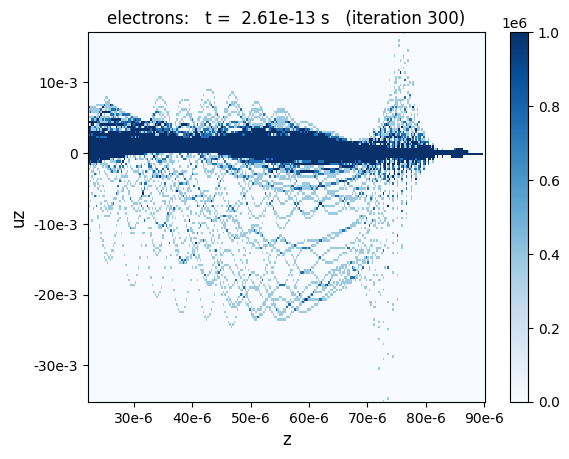

In [10]:
%%time
# Plot the blue phase space with all the electrons
geos_ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True, vmax=1e6 );

first level match num: 36
second level match num: 360


32456
CPU times: user 56.3 ms, sys: 603 µs, total: 56.9 ms
Wall time: 55.9 ms


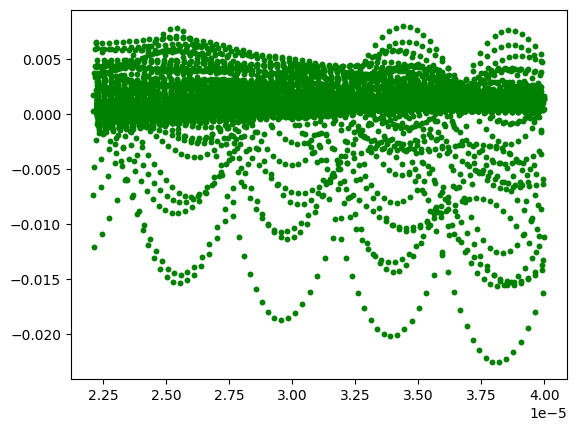

In [11]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[22e-6,40e-6]} )
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

using openpmd-api backend to read data
using openpmd-api backend to read data

first level match num: 36
second level match num: 360


CPU times: user 98.2 ms, sys: 11.4 ms, total: 110 ms
Wall time: 107 ms


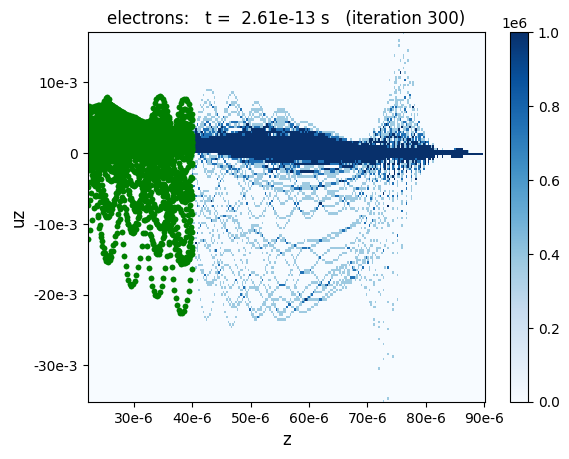

In [12]:
%%time
# Plot the blue phase space with all the electrons
geos_ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True, vmax=1e6 );
# Select only particles that have uz between 0.05 and 0.2
# and plot them as green dots, on top of the phase space
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'z':[22e-6,40e-6]} )
plt.plot(z_selected, uz_selected, 'g.')



first level match num: 1
second level match num: 1
2
CPU times: user 16.2 ms, sys: 276 µs, total: 16.4 ms
Wall time: 15 ms


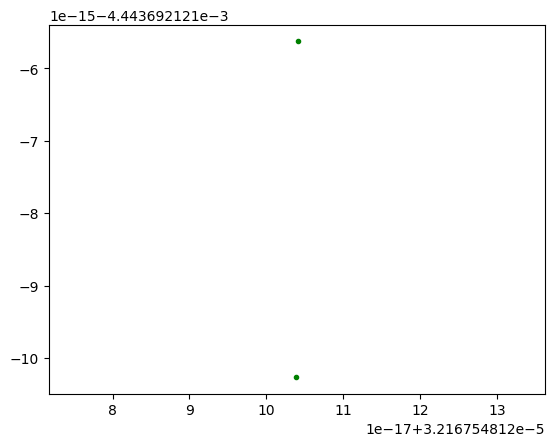

In [13]:
%%time
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'x':[-6.996e-7, 6.996e-7], 'y':[-0.06996e-7, 0.06996e-7], 'z':[22e-6,40e-6]} )
plt.plot(z_selected, uz_selected, 'g.')
print(len(z_selected))

using openpmd-api backend to read data
using openpmd-api backend to read data



CPU times: user 67.7 ms, sys: 43.6 ms, total: 111 ms
Wall time: 62.2 ms
first level match num: 1
second level match num: 1


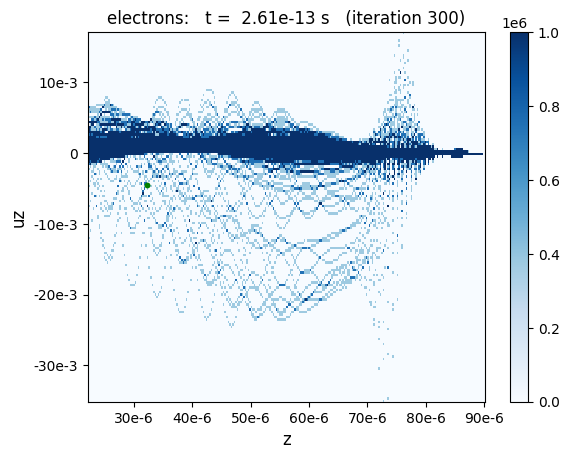

In [14]:
%%time

# Plot the blue phase space with all the electrons
geos_ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True,vmax=1e6 );

# Select only particles that have uz between 0.05 and 0.2 AND z between 22 and 26
# and plot them as green dots, on top of the phase space
z_selected, uz_selected = geos_ts.get_particle( ['z', 'uz'], species='electrons',
                            iteration=300, select={'x':[-6.996e-7, 6.996e-7], 'y':[-0.06996e-7, 0.06996e-7], 'z':[22e-6,40e-6]} )
plt.plot(z_selected, uz_selected, 'g.')

## Tracking particles

While selecting particles only involves one iteration, tracking particles consist in:
- selecting particles at a given iteration
- retrieving the same particles at another iteration

The first step (selecting particles at a given iteration) is done by creating an instance of the `ParticleTracker` class.

In [15]:
from openpmd_viewer import ParticleTracker
# Select particles to be tracked, at iteration 300
# pt = ParticleTracker( ts, iteration=300, select={'uz':[0.05,0.2], 'z':[22e-6,26e-6]}, species='electrons' )
pt = ParticleTracker( ts, iteration=300, select={'uz':[1e-3, 0.2], 'z':[22e-6,90e-6]}, species='electrons' )
# some particles would not appear in the next iteration
# pt = ParticleTracker( ts, iteration=300, select={'uz':[1e-3, 0.2], 'z':[22e-6,40e-6]}, species='electrons' )

using openpmd-api backend to read data



The second step (retrieving the same particles) is done by passing the `ParticleTracker` instance to the method `get_particle` as `select` (instead of a dictionary), as in the example below.

using openpmd-api backend to read data
using openpmd-api backend to read data

using openpmd-api backend to read data
using openpmd-api backend to read data



/data/gc/rocksdb-index/openPMD-viewer/openpmd_viewer/openpmd_timeseries/numba_wrapper.py:24: UserWarning: 
One of the functions called by openPMD-viewer (extract_indices)
could have been faster if `numba` had been installed.
Please consider installing `numba` (e.g. `pip install numba`)
  warnings.warn(


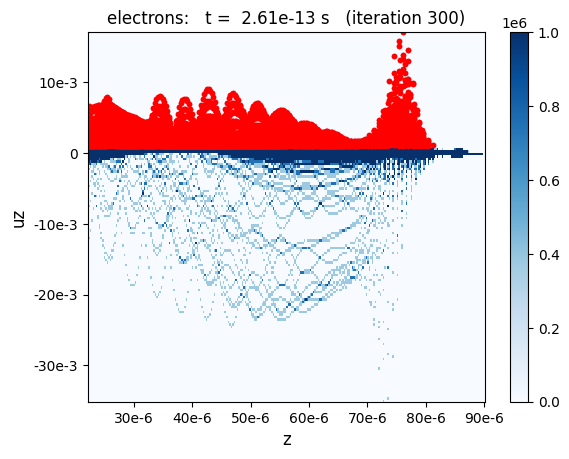

In [16]:
plot_iteration = 300

# Plot the blue phase space with all the electrons
ts.get_particle( ['z', 'uz'], species='electrons', iteration=plot_iteration, plot=True, vmax=1e6 );

# Plot the tracked particles as red dots, on top of the phase space
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons', iteration=plot_iteration, select=pt )
plt.plot(z_selected, uz_selected, 'r.')

The key point is that, when tracking particles, the iteration at which particles are retrieved can be different then the one at which they are selected, as in the example below:

using openpmd-api backend to read data
using openpmd-api backend to read data

using openpmd-api backend to read data
using openpmd-api backend to read data



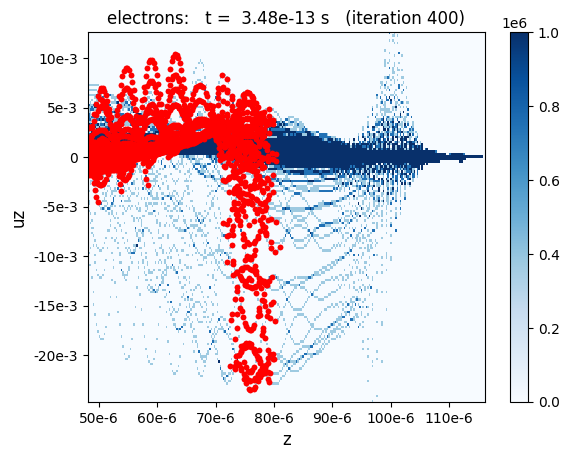

In [17]:
plot_iteration = 400

# Plot the blue phase space with all the electrons
ts.get_particle( ['z', 'uz'], species='electrons', iteration=plot_iteration, plot=True, vmax=1e6 );

# Plot the tracked particles as red dots, on top of the phase space
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons', iteration=plot_iteration, select=pt )
plt.plot(z_selected, uz_selected, 'r.')

## Reconstructing particle trajectories

Particle tracking can also be used in order to reconstruct individual particle trajectories, across several iterations.

However in order to do so, we need to be sure that, each time we retrieve particles (as arrays), the same individual particle is always at the same index of the array. This can be enabled with `ParticleTracker`, by using the argument `preserve_particle_index`.

In [18]:
pt = ParticleTracker( ts, iteration=300, select={'uz':[0.05,0.1], 'z':[22e-6,26e-6]}, 
                         species='electrons', preserve_particle_index=True )

using openpmd-api backend to read data



Using this, we can now reconstruct a set of trajectories:

In [19]:
N_iterations = len(ts.iterations)
N_particles = pt.N_selected

uz_trajectories = np.empty( ( N_iterations, N_particles ) )
for i in range( N_iterations ):
    uz, = ts.get_particle( ['uz'], select=pt, iteration=ts.iterations[i], species='electrons' )
    uz_trajectories[i, :] = uz[:]

using openpmd-api backend to read data

using openpmd-api backend to read data

using openpmd-api backend to read data

using openpmd-api backend to read data

using openpmd-api backend to read data

using openpmd-api backend to read data



and plot the trajectories of a few particles (specifically those that are at index 0, 10 and 19).

In [20]:
plt.plot( ts.iterations, uz_trajectories[:,0], '-o' )
plt.plot( ts.iterations, uz_trajectories[:,10], '-o' )
plt.plot( ts.iterations, uz_trajectories[:,19], '-o' )

plt.xlabel('Iteration')
plt.ylabel('Longitudinal momentum uz')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/local/ASUAD/cguo51/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_395985/2186702868.py", line 1, in <module>
    plt.plot( ts.iterations, uz_trajectories[:,0], '-o' )
IndexError: index 0 is out of bounds for axis 1 with size 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/local/ASUAD/cguo51/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/local/ASUAD/cguo51/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1396, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/local/ASUAD/cguo51/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1287, in structured_traceback
    return 

Note that reconstructing the trajectories can also be done with the method `ts.iterate`, in order to avoid having to explicitly write the above loops:

In [ ]:
z_trajectories, uz_trajectories = ts.iterate( ts.get_particle, ['z', 'uz'], select=pt, species='electrons' )

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot( ts.iterations, z_trajectories[:,0], '-o' )
plt.plot( ts.iterations, z_trajectories[:,10], '-o' )
plt.plot( ts.iterations, z_trajectories[:,19], '-o' )
plt.ylabel('Longitudinal position z')
plt.xlabel('Iteration')

plt.subplot(122)
plt.plot( ts.iterations, uz_trajectories[:,0], '-o' )
plt.plot( ts.iterations, uz_trajectories[:,10], '-o' )
plt.plot( ts.iterations, uz_trajectories[:,19], '-o' )
plt.ylabel('Longitudinal momentum uz')
plt.xlabel('Iteration')
plt.tight_layout()